### Exploring representational spaces in non-language, English, German

how wells does cosine predict kl?

In [109]:
from collections import defaultdict
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd
import pickle
import sys
import tqdm

from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import seaborn as sns
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy.lang.de.examples import sentences
from spacy.tokenizer import Tokenizer

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from sapir_image_captions import GLOBAL_TOKENS, SOS_TOKEN, EOS_TOKEN, PAD_TOKEN
from sapir_image_captions.checkpoints import load_checkpoint
from sapir_image_captions.multi_30k.dataset import CaptionTask2Dataset
from sapir_image_captions.models import batch_beam_search_caption_generation, beam_search_caption_generation
from sapir_image_captions.utils import text2tensor, tensor2text, remove_tokens

Data loading

In [2]:
data_dir = "/Users/benpeloquin/Data/projects/sapir_image_captions/trained_models/model_as_participant_out_20190520"
model_path_creater = lambda language, version: "model_data_{}_{}_2016.pickle".format(language, version)

In [3]:
de_fp_1 = os.path.join(data_dir, model_path_creater("de", 1))
en_fp_1 = os.path.join(data_dir, model_path_creater("en", 1))
de_fp_2 = os.path.join(data_dir, model_path_creater("de", 2))
en_fp_2 = os.path.join(data_dir, model_path_creater("en", 2))
de_fp_3 = os.path.join(data_dir, model_path_creater("de", 3))
en_fp_3 = os.path.join(data_dir, model_path_creater("en", 3))

In [4]:
with open(de_fp_1, "rb") as fp:
    d_de_1 = pickle.load(fp)
with open(en_fp_1, "rb") as fp:
    d_en_1 = pickle.load(fp)
with open(de_fp_2, "rb") as fp:
    d_de_2 = pickle.load(fp)
with open(en_fp_2, "rb") as fp:
    d_en_2 = pickle.load(fp)
with open(de_fp_3, "rb") as fp:
    d_de_3 = pickle.load(fp)
with open(en_fp_3, "rb") as fp:
    d_en_3 = pickle.load(fp)

In [6]:
print(d_en_1.keys())

dict_keys(['num_batches', 'language', 'version', 'year', 'images', 'target_captions', 'target_caption_lens', 'recon_captions', 'recon_caption_lens', 'alphas', 'language_hiddens', 'image_hiddens'])


In [7]:
en_target_captions = [x for xs in d_en_1["target_captions"] for x in xs]
de_target_captions = [x for xs in d_de_1["target_captions"] for x in xs]
en_recon_captions_1 = [x for xs in d_en_1["recon_captions"] for x in xs]
de_recon_captions_1 = [x for xs in d_de_1["recon_captions"] for x in xs]

In [8]:
# Numbers check...
assert len(set(map(len, [en_target_captions, 
                     de_target_captions, 
                     en_recon_captions_1, 
                     de_recon_captions_1]))) == 1

In [12]:
len(d_en_1["language_hiddens"])
len(d_en_1['recon_captions'])

16

In [18]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [84]:
# Helper
def get_all_datas(model, parser=en_nlp):
    """
    Parameters
    ----------
    model: dict
        One of model_data_{}_{}_2016.pickle objects.
    parser: spacy parser
        Returned from spacy.load()
    
    Returns
    -------
    dict
        Avgerage/individual language hiddens, 
        recon captions, recon pos, recon alpha
    
    """
    all_avg_hiddens = []
    all_hiddens = []
    all_tokens = []
    all_pos = []
    all_alphas = []
    
    n_batches = len(model["language_hiddens"])
    for batch_idx in tqdm.tqdm(range(n_batches)):
        # Hiddens
        for sent_hiddens in model["language_hiddens"][batch_idx]:
            sent_hiddens = sent_hiddens[1:-1]
            avg_hiddens_vector = sent_hiddens.mean(0)
            all_avg_hiddens.append(avg_hiddens_vector)
            for token_hiddens in sent_hiddens:
                all_hiddens.append(token_hiddens)                

        # Tokens / POS
        for sent_text in model["recon_captions"][batch_idx]:
            d_parsed = parser(sent_text)
            all_tokens.append([parsed.text for parsed in d_parsed])
            all_pos.append([parsed.pos_ for parsed in d_parsed])
        
        # Alphas
        for sent_alphas in model["alphas"][batch_idx]:
            all_alphas.append(sent_alphas.mean(0) / sent_alphas.mean(0).sum())
            
    return {"all_avg_hiddens": all_avg_hiddens, 
            "all_hiddens": all_hiddens, 
            "all_tokens": all_tokens, 
            "all_pos": all_pos, 
            "all_alphas": all_alphas}


In [85]:
# Get data
models = [('en1', d_en_1), ('en2', d_en_2), ('en3', d_en_3), 
          ('de1', d_de_1), ('de2', d_de_2), ('de3', d_de_3)]

all_data = {}
for model_nam, model in models:
    if 'en' in model_nam:
        all_data[model_nam] = get_all_datas(model, en_nlp)
    elif 'de' in model_nam:
        all_data[model_nam] = get_all_datas(model, de_nlp)
    else:
        raise Exception("How did this happen???")


100%|██████████| 16/16 [00:06<00:00,  2.31it/s]


In [88]:
# Resnet encodings
X_images = np.concatenate(d_en_1["image_hiddens"])
all_data["image"] = {"all_avg_hiddens": X_images}

# Coarse look at representational spaces 

In [89]:
pca = PCA(n_components=2)
pca_hold = {"image": pca.fit_transform(X_images)}
for model_name in tqdm.tqdm(all_data.keys()):
    pca_hold[model_name] = pca.fit_transform(np.array(all_data[model_name]["all_avg_hiddens"]))

100%|██████████| 7/7 [00:07<00:00,  1.04s/it]


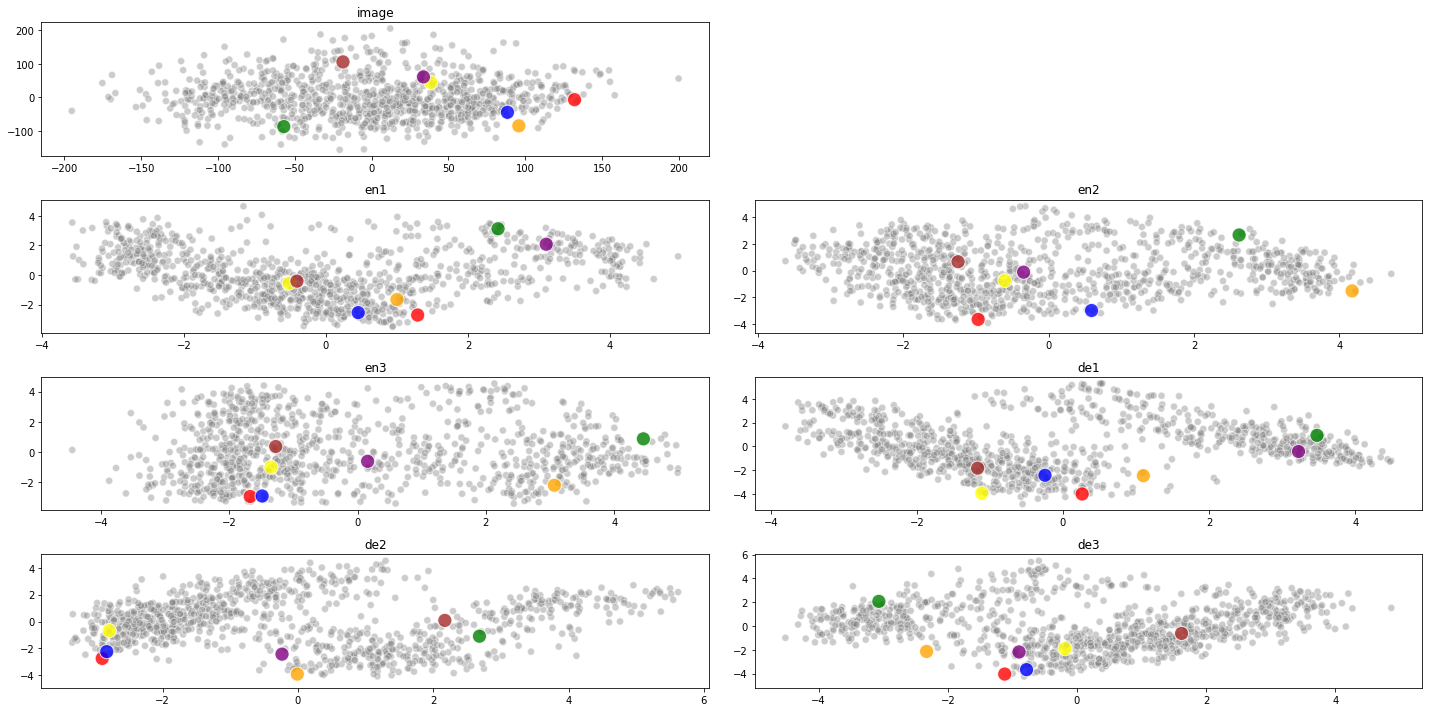

In [90]:
n_models = len(pca_hold)
# n_rows = n_cols = int(np.ceil(np.sqrt(len(pca_hold.keys()))))
n_rows, n_cols = 4, 2
n_normal = 993
n_special = len(pca_hold["image"]) - n_normal
col = ['grey' for _ in range(n_normal)] + ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown']
sizes = [50 for _ in range(n_normal)] + [200 for _ in range(n_special)]

plt.figure(figsize=(20, 10))
for i, (model_name, X) in enumerate(pca_hold.items(), 1):
    if i > 1:
        plt.subplot(n_rows, n_cols, i+1)
    else:
        plt.subplot(n_rows, n_cols, i)
    plt.title("{}".format(model_name))
    plt.scatter(X[:n_normal, 0], X[:n_normal, 1], 
            c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
    plt.scatter(X[n_normal:, 0], X[n_normal:, 1], 
            c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])
plt.tight_layout()

tSNE

First run PCA to 50dims, then tSNE

**SLOW RUNNING**

In [91]:
# pca = PCA(n_components=50)
# image_pca = pca.fit_transform(X_images)
# en_pca_1 = pca.fit_transform(en_hiddens_1)
# de_pca_1 = pca.fit_transform(de_hiddens_1)
# en_pca_2 = pca.fit_transform(en_hiddens_2)
# de_pca_2 = pca.fit_transform(de_hiddens_2)

# tsne = TSNE(n_components=2)
# image_tsne = tsne.fit_transform(image_pca)
# en_tsne_1 = tsne.fit_transform(en_pca_1)
# de_tsne_1 = tsne.fit_transform(de_pca_1)
# en_tsne_2 = tsne.fit_transform(en_pca_2)
# de_tsne_2 = tsne.fit_transform(de_pca_2)

In [92]:
# n_normal = 993
# n_special = len(image_pca) - n_normal
# col = ['grey' for _ in range(n_normal)] + ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'brown']
# sizes = [50 for _ in range(n_normal)] + [200 for _ in range(n_special)]

# plt.figure(figsize=(12, 6))
# plt.subplot(3, 2, 1)
# plt.title("resnet101")
# plt.scatter(image_tsne[:n_normal, 0], image_tsne[:n_normal, 1], 
#             c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
# plt.scatter(image_tsne[n_normal:, 0], image_tsne[n_normal:, 1], 
#             c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])

# plt.subplot(3, 2, 3)
# plt.title("en")
# plt.scatter(en_tsne_1[:n_normal, 0], en_tsne_1[:n_normal, 1], 
#             c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
# plt.scatter(en_tsne_1[n_normal:, 0], en_tsne_1[n_normal:, 1], 
#             c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])

# plt.subplot(3, 2, 4)
# plt.title("de")
# plt.scatter(de_tsne_1[:n_normal, 0], de_tsne_1[:n_normal, 1], 
#             c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
# plt.scatter(de_tsne_1[n_normal:, 0], de_tsne_1[n_normal:, 1], 
#             c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])

# plt.subplot(3, 2, 5)
# plt.title("en 2")
# plt.scatter(en_tsne_2[:n_normal, 0], en_tsne_2[:n_normal, 1], 
#             c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
# plt.scatter(en_tsne_2[n_normal:, 0], en_tsne_2[n_normal:, 1], 
#             c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])

# plt.subplot(3, 2, 6)
# plt.title("de 2")
# plt.scatter(de_tsne_2[:n_normal, 0], de_tsne_2[:n_normal, 1], 
#             c=col[:n_normal], cmap='hsv', alpha=0.4, edgecolors='w', s=sizes[:n_normal])
# plt.scatter(de_tsne_2[n_normal:, 0], de_tsne_2[n_normal:, 1], 
#             c=col[n_normal:], cmap='hsv', alpha=0.8, edgecolors='w', s=sizes[n_normal:])
# plt.tight_layout()

In [94]:
def get_image_by_image_corrs(X):
    x = np.corrcoef(np.array(X))
    return x[np.triu_indices(len(x), k=1)]

d_image_corrs = {}
for model_name in tqdm.tqdm(all_data.keys()):
    d_image_corrs[model_name] = get_image_by_image_corrs(all_data[model_name]["all_avg_hiddens"])

In [135]:
combs = [("en1", "en2"),
         ("en1", "en3"),
         ("en2", "en3"),
         ("image", "en1"),
         ("image", "en2"),
         ("image", "en3"),
         ("de1", "de2"),
         ("de1", "de3"),
         ("de2", "de3"),
         ("image", "de1"),
         ("image", "de2"),
         ("image", "de3")]
d_corr_res = []
for comb in combs:
    a, b = comb
    d_corr_res.append({
        "datas": "{}-{}".format(*comb),
        "r": np.corrcoef(d_image_corrs[a], d_image_corrs[b])[0][1]
    })
    
df_corr_res = pd.DataFrame(d_corr_res)

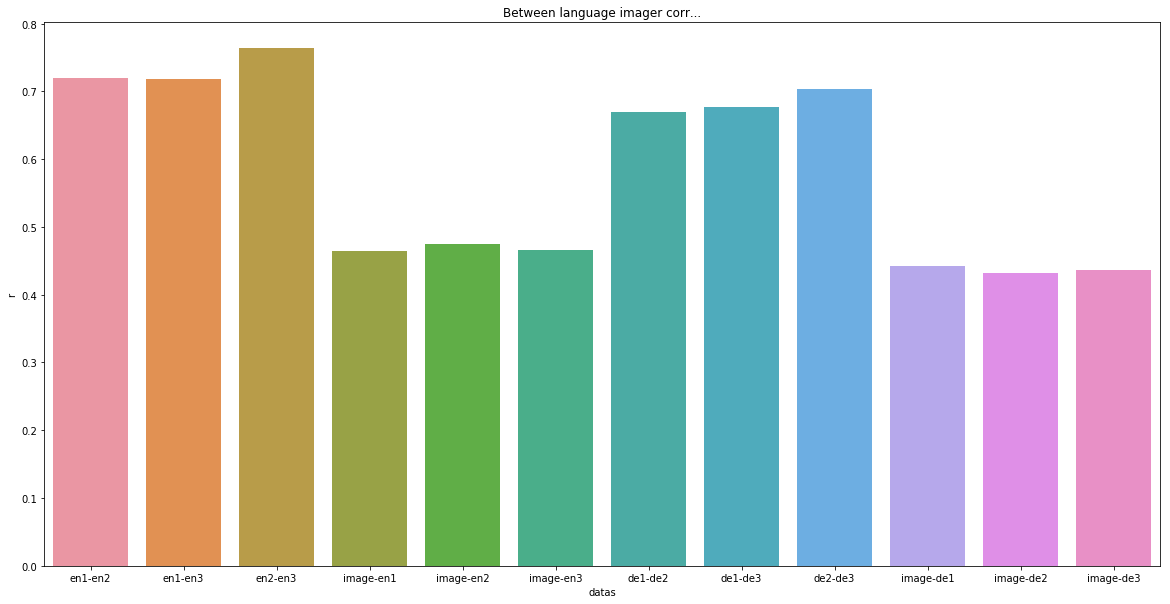

In [136]:
plt.figure(figsize=(20, 10))
plt.title("Between language imager corr...")
sns.barplot(x="datas", y="r", data=df_corr_res)

In [116]:
d_cosines = {}
for model_name in all_data.keys():
    X = all_data[model_name]["all_avg_hiddens"]
    d_cosines[model_name] = cosine_similarity(X)
    

# image_cosine = cosine_similarity(all_data["image"]["all_avg_hiddens"])
# en_cosine = cosine_similarity(en_hiddens_1)
# de_cosine = cosine_similarity(de_hiddens_1)

In [68]:
print(np.corrcoef(image_cosine.flatten(), en_cosine.flatten())[0][1])
print(np.corrcoef(image_cosine.flatten(), de_cosine.flatten())[0][1])
print(np.corrcoef(en_cosine.flatten(), de_cosine.flatten())[0][1])


0.40883523091187046
0.41341994056602666
0.6390873428058245


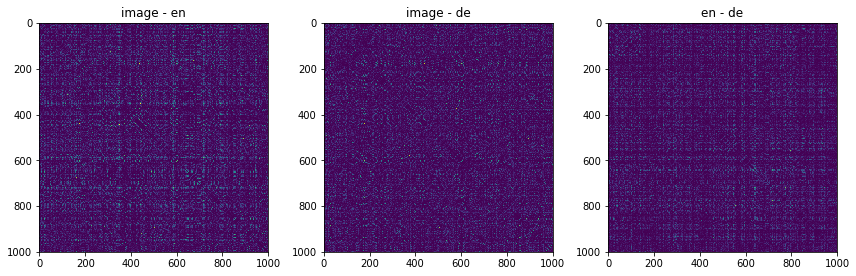

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("image - en")
plt.imshow((image_cosine - en_cosine)**2)
plt.subplot(1, 3, 2)
plt.title("image - de")
plt.imshow((image_cosine - de_cosine)**2)
plt.subplot(1, 3, 3)
plt.title("en - de")
plt.imshow((en_cosine - de_cosine)**2)
plt.tight_layout()

# Attention saliency maps

In [114]:
def get_row_col(idx, total=1000):
    return int(idx/total), idx % 1000

In [124]:
IMAGES_DIR = "/Users/benpeloquin/Data/general/multi30k/data/task2/image_splits/test_2016_images.txt"
IMAGES_CONTAINER = "/Users/benpeloquin/Data/general/multi30k/flickr30k-images/"

en_de_max = np.argmax(((d_cosines["en1"] - d_cosines["de1"])))
en_de_min = np.argmin(((d_cosines["en1"] - d_cosines["de1"])))

# en_alphas = []
# for batch in all_data["en1"]['all_alphas']:
#     for sent in batch:
#         en_alphas.append(sent.mean(0) / sent.mean(0).sum())
# de_alphas = []
# for batch in all_data["de1"]['all_alphas']:
#     for sent in batch:
#         import pdb; pdb.set_trace();
#         de_alphas.append(sent.mean(0) / sent.mean(0).sum())
# X_en_alphas = np.array(en_alphas)
# X_de_alphas = np.array(de_alphas)

In [129]:
def get_kl(d1, d2):
    return np.sum(d1 * np.log(d1 / d2))


non_image_combs = [("en1", "en2"),
                   ("en1", "en3"),
                   ("en2", "en3"),
                   ("de1", "de2"),
                   ("de1", "de3"),
                   ("de2", "de3"),
                   ("en1", "de1"),
                   ("en1", "de2"),
                   ("en1", "de3"),
                   ("en2", "de1"),
                   ("en2", "de2"),
                   ("en2", "de3"),
                   ("en3", "de1"),
                   ("en3", "de2"),
                   ("en3", "de3")]

all_kls = []

n_images = 1000
d_alphas = defaultdict(list)
for comb in non_image_combs:
    a, b = comb
    for img_idx in range(n_images):
        alphas_1 = all_data[a]["all_alphas"][img_idx]
        alphas_2 = all_data[b]["all_alphas"][img_idx]
        kl = get_kl(alphas_1, alphas_2)
        d_alphas["{}-{}".format(a, b)].append(kl)

# for img_idx in range(len(all_data["en1"]["all_alphas"])):
#     en_alphas = all_data["en1"]["all_alphas"][img_idx]
#     de_alphas = all_data["de1"]["all_alphas"][img_idx]
# #     de_alphas = X_de_alphas[img_idx, :]
#     kl = get_kl(en_alphas, de_alphas)
#     all_kls.append(kl) 

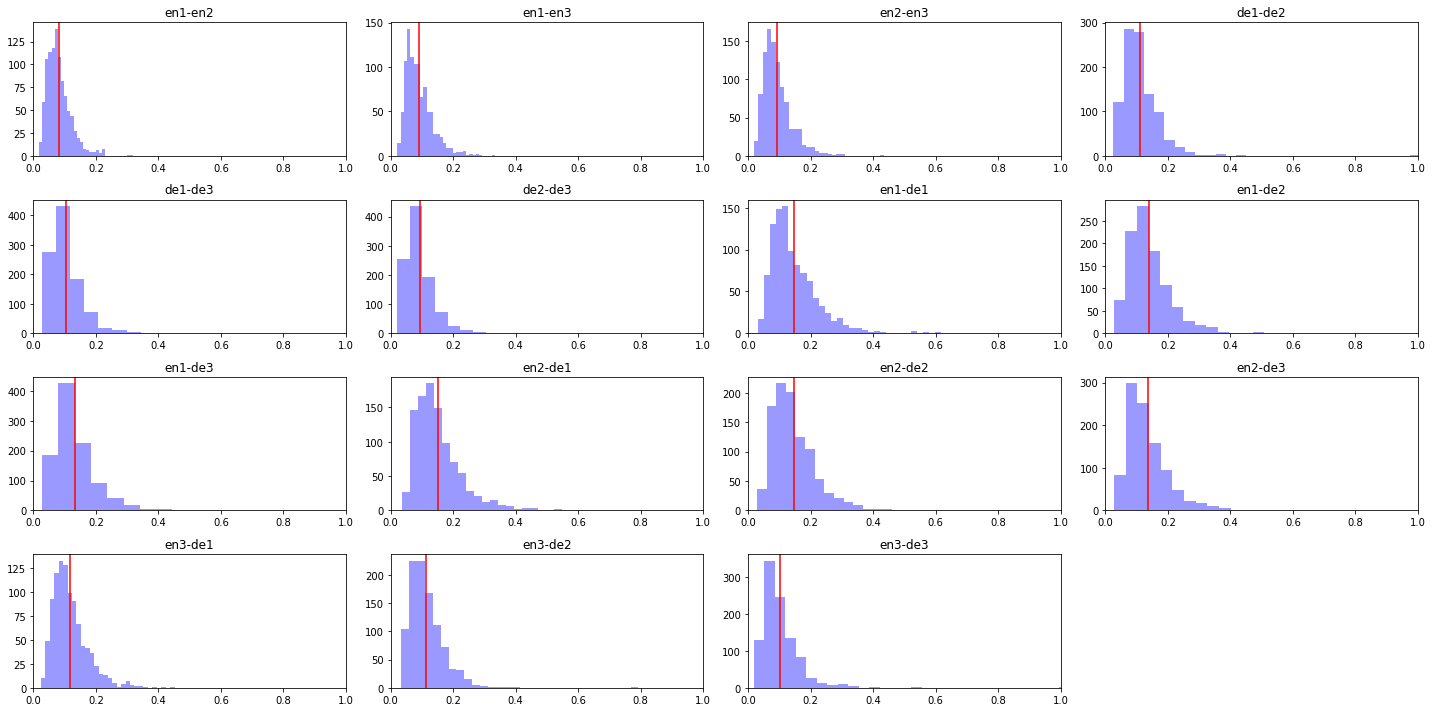

In [140]:
plt.figure(figsize=(20, 10))
for i, (comb, kls) in enumerate(d_alphas.items(), 1):
    plt.subplot(4, 4, i)
    plt.title("{}".format(comb))
    plt.hist(kls, bins=30, color="blue", alpha=0.4)
    plt.xlim(0, 1)
    plt.axvline(np.mean(kls), color="red")
plt.tight_layout()

In [28]:
np.where(np.array(all_kls) > 0.3)

(array([ 37,  71, 127, 143, 147, 148, 169, 184, 212, 222, 243, 278, 282,
        297, 354, 407, 451, 470, 493, 544, 562, 631, 636, 653, 665, 667,
        670, 678, 681, 696, 707, 790, 798, 804, 805, 813, 842, 850, 859,
        878, 888, 890, 948]),)

In [155]:
def get_caption(idx, data):
    return data[idx]

def get_image_path(idx, images_fp=IMAGES_CONTAINER):
    """Indexing into test images..."""
    images = pd.read_csv(images_fp, sep=" ", header=None) \
        .values \
        .squeeze() \
        .tolist()
    return images[idx]

def load_image(idx, images_directory=IMAGES_DIR, images_container=IMAGES_CONTAINER):
    """Returns a numpy array of the image."""
    image_name = get_image_path(idx, images_directory)
    image_fp = os.path.join(images_container, image_name)
    return plt.imread(image_fp)

def visualize_image(idx, images_fp=IMAGES_CONTAINER):
    return plt.imshow(load_image(idx, images_fp))

def visualize_2_images(idx1, idx2, images_fp=IMAGES_DIR, overlay_alphas=False):
    img1 = load_image(idx1, images_fp)
    img2 = load_image(idx2, images_fp)
    
    if not overlay_alphas:
        plt.subplot(1, 2, 1)
        plt.imshow(img1)
        plt.subplot(1, 2, 2)
        plt.imshow(img2)
    else:
        v_en1 = X_en_alphas[idx1].reshape(-1)
        v_de1 = X_de_alphas[idx1].reshape(-1)
        v_en2 = X_en_alphas[idx2].reshape(-1)
        v_de2 = X_de_alphas[idx2].reshape(-1)
        kl1 = np.sum(v_en1 * np.log(v_en1/v_de1))
        kl2 = np.sum(v_en2 * np.log(v_en2/v_de2))
        alphas1 = resize(X_en_alphas[idx1] - X_de_alphas[idx1], img1.shape[:2])
        alphas2 = resize(X_en_alphas[idx2] - X_de_alphas[idx2], img2.shape[:2])
        plt.subplot(1, 2, 1)
        plt.imshow(alphas1, cmap="magma")
        plt.imshow(img1, alpha=0.4)
        print(get_caption(idx1, en_recon_captions_1))
        print(get_caption(idx1, de_recon_captions_1))
        plt.subplot(1, 2, 2)
        plt.imshow(alphas2, cmap="magma")
        plt.imshow(img2, alpha=0.4)
        print(get_caption(idx2, en_recon_captions_1))
        print(get_caption(idx2, de_recon_captions_1))
        print("kl1:\t{}".format(kl1))
        print("kl2:\t{}".format(kl2))
    return

a man in a white shirt is riding a bike in a park .
ein mann fährt auf einem fahrrad .
a man in a white shirt stands in front of a building .
ein mann auf einem gerüst .
kl1:	0.0
kl2:	0.0


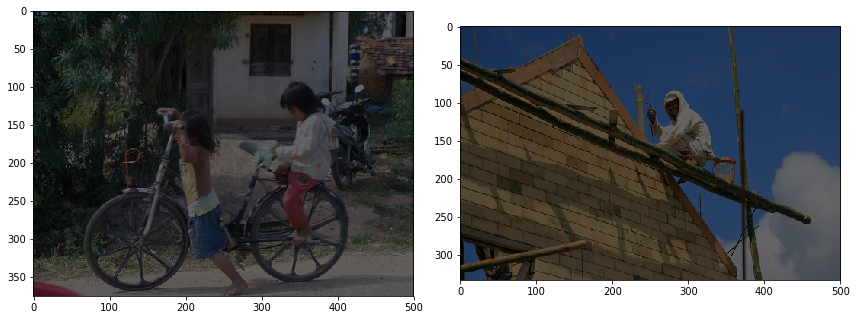

In [156]:
plt.figure(figsize=(12, 6))
img1, img2 = get_row_col(en_de_max)
visualize_2_images(850, 859, overlay_alphas=True)
plt.tight_layout()

# POS analysis

In [157]:

dir(Tokenizer)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_load_special_tokenization',
 '_reset_cache',
 'add_special_case',
 'find_infix',
 'find_prefix',
 'find_suffix',
 'from_bytes',
 'from_disk',
 'infix_finditer',
 'pipe',
 'prefix_search',
 'suffix_search',
 'to_bytes',
 'to_disk',
 'token_match',
 'tokens_from_list',
 'vocab']

In [158]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [159]:
# Simplify tokenization...
# http://www.longest.io/2018/01/27/spacy-custom-tokenization.html
import re
def create_custom_tokenizer(nlp):
    prefix_re = re.compile('\s')
    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search)
en_tokenizer = create_custom_tokenizer(en_nlp)
de_tokenizer = create_custom_tokenizer(de_nlp)
en_nlp.tokenizer = en_tokenizer
de_nlp.tokenizer = de_tokenizer

In [160]:
# tokens and pos lists...

# en 1
en_sents_tokens_1 = []
en_sents_pos_1 = []
for batch in tqdm.tqdm(d_en_1['recon_captions']):
    for sent in batch:
        d_parsed = en_nlp(sent)
        en_sents_tokens_1.append([parsed.text for parsed in d_parsed])
        en_sents_pos_1.append([parsed.pos_ for parsed in d_parsed])

# en 2
en_sents_tokens_2 = []
en_sents_pos_2 = []
for batch in tqdm.tqdm(d_en_2['recon_captions']):
    for sent in batch:
        d_parsed = en_nlp(sent)
        en_sents_tokens_2.append([parsed.text for parsed in d_parsed])
        en_sents_pos_2.append([parsed.pos_ for parsed in d_parsed])

# de 1
de_sents_tokens_1 = []
de_sents_pos_1 = []
for batch in tqdm.tqdm(d_de_1['recon_captions']):
    for sent in batch:
        d_parsed = de_nlp(sent)
        de_sents_tokens_1.append([parsed.text for parsed in d_parsed])
        de_sents_pos_1.append([parsed.pos_ for parsed in d_parsed])

# de 2
de_sents_tokens_2 = []
de_sents_pos_2 = []
for batch in tqdm.tqdm(d_de_2['recon_captions']):
    for sent in batch:
        d_parsed = de_nlp(sent)
        de_sents_tokens_2.append([parsed.text for parsed in d_parsed])
        de_sents_pos_2.append([parsed.pos_ for parsed in d_parsed])

100%|██████████| 16/16 [00:05<00:00,  2.82it/s]


In [161]:
X_en_alpha_sents_1 = []
for idx, batch in enumerate(d_en_1['alphas']):
    for sent in batch:
        X_en_alpha_sent = []
        for token in sent:
            X_en_alpha_sent.append(np.array(token))
        X_en_alpha_sents_1.append(np.array(X_en_alpha_sent))
        
X_de_alpha_sents_1 = []
for idx, batch in enumerate(d_de_1['alphas']):
    for sent in batch:
        X_de_alpha_sent = []
        for token in sent:
            X_de_alpha_sent.append(np.array(token))
        X_de_alpha_sents_1.append(np.array(X_de_alpha_sent))

In [30]:
def visualize_sent(img_idx, sent_alphas, sent_tokens, sent_pos):
    """Sent is an array of 14 X 14 matrices."""
    total = len(sent_alphas)
    for token_idx, token_alphas in enumerate(sent_alphas):
        curr_idx = token_idx + 1
        half = int(total / 2) 
        plt.subplot(half, half, curr_idx)
        img = load_image(img_idx)
        alphas = resize(token_alphas, img.shape[:2])
        plt.imshow(alphas, cmap="magma")
        plt.imshow(img, alpha=0.4)
        plt.title("{}\n{}".format(sent_tokens[token_idx], sent_pos[token_idx]))

In [31]:
plt.figure(figsize=(12, 6))
target_idx = 0
visualize_sent(target_idx, 
               X_en_alpha_sents_1[target_idx], 
               en_sents_tokens_1[target_idx], 
               en_sents_pos_1[target_idx])
plt.tight_layout()

NameError: name 'en_sents_tokens_1' is not defined

<Figure size 864x432 with 0 Axes>

In [154]:
plt.figure(figsize=(12, 6))
target_idx = 0
visualize_sent(target_idx, 
               X_de_alpha_sents_1[target_idx], 
               de_sents_tokens_1[target_idx], 
               de_sents_pos_1[target_idx])
plt.tight_layout()

NameError: name 'visualize_sent' is not defined

<Figure size 864x432 with 0 Axes>

In [170]:
def pos_analysis(sent_alphas, sent_pos):
    res = defaultdict(list)
    for token_idx, token_alphas in enumerate(sent_alphas):
        curr_pos = sent_pos[token_idx]
        res[curr_pos].append(token_alphas)
    res_2 = {}
    for k, v in res.items():
        x = np.stack(v)
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        res_2[k] = x.mean(0) / x.mean(0).sum()
    return res_2

# pos_analysis(X_de_alpha_sents_1[target_idx], de_sents_pos_1[target_idx])['DET']

Idea is to look at alpha distributions over different `pos`

In [171]:
def get_alpha_kl(a1, a2):
    return np.sum(a1 * np.log(a1 / a2))

d_pos = []
for img_idx in range(len(X_en_alpha_sents_1)):
    en_img = X_en_alpha_sents_1[img_idx]
    de_img = X_de_alpha_sents_1[img_idx]
    en_pos = pos_analysis(X_en_alpha_sents_1[img_idx], en_sents_pos_1[img_idx])
    de_pos = pos_analysis(X_de_alpha_sents_1[img_idx], de_sents_pos_1[img_idx])
    d_pos.append((en_pos, de_pos))
    
pos_capture = defaultdict(list)
for en_alpha_data, de_alpha_data in d_pos:
    shared_pos = set(en_alpha_data.keys()) & set(de_alpha_data.keys())
    for pos in shared_pos:
        pos_capture[pos].append(get_alpha_kl(en_alpha_data[pos], en_alpha_data[pos], de_alpha_data[pos]))


In [172]:
pos_capture.keys()
n_pos = len(pos_capture.keys())

In [ ]:
plt.figure(figsize=(20, 10))
cols = ["red", "blue", "grey", "yellow", "green", "purple", "orange", "brown", "black", "tan"]
for key_id, (pos, en, de) in enumerate(pos_capture.items()):
    import pdb; pdb.set_trace();
    curr_color = cols[key_id]
    plt.subplot(n_pos/2, n_pos/2, key_id+1)
    plt.hist(de, color=curr_color, alpha=0.4)
    plt.title("{}, n={}, {}".format(pos, len(de), round(np.mean(de), 3)))
    plt.xlim(0, 6)
plt.tight_layout()

Tracing the trajectory through latent space

In [144]:
# first_caption = d_en['recon_captions'][0][0].split()
X_recon_captions_lens_1 = [j for x in d_de_1['recon_caption_lens'] for j in x]
X_recon_captions_1 = [j.split() for x in d_de_1['recon_captions'] for j in x]
caption_idxs = np.cumsum(X_recon_captions_lens_1)

All words

**Todo** pos parsing is slightly off leading to problems (words like `t-shirt`)

In [145]:
de_words_1 = [word for sent in X_recon_captions_1 for word in sent]

In [146]:
de_sent_hiddens_1 = []
for batch in d_de_1["language_hiddens"]:
    for sent in batch:
        for x in sent[1:-1]:
            de_sent_hiddens_1.append(x)
                
X_de_sents_1 = np.stack(de_sent_hiddens_1)

In [147]:
def get_sent_index_bounds(sent_num):
    return X_recon_captions_1[sent_num:sent_num+1][0], X_recon_captions_lens_1[sent_num:sent_num+1][0]
get_sent_index_bounds(1)


(['ein', 'hund', 'rennt', 'über', 'eine', 'wiese', '.'], 7)

In [148]:
def plot_sent_trajectory(idx, c="blue"):
    target_start = idx
    target_sent, target_jump = get_sent_index_bounds(target_start)
    target_hiddens = np.stack(X_de_sents_1[target_start:target_start+target_jump, :])
    X_de_sents_np = np.stack(X_de_sents_1)
    
    pca = PCA(n_components=2)
    de_pca = pca.fit(X_de_sents_np)
    d_all_de = pca.transform(X_de_sents_np)
    d_target = pca.transform(target_hiddens)
    idxs_order = np.random.permutation(range(d_all_de.shape[0]))
    plt.scatter(d_all_de[idxs_order, 0], d_all_de[idxs_order, 1], 
                c=X_colors, cmap='Accent', alpha=0.2)
    plt.plot(d_target[:, 0], d_target[:, 1], '-o', color=c, alpha=0.6)
    n_tokens = len(target_sent)
    half_tokens = int(n_tokens/2)
    plt.title('{}\n{}'.format(' '.join(target_sent[: half_tokens]), 
                              ' '.join(target_sent[half_tokens: ])))
    for i, (x, y) in enumerate(zip(d_target[:, 0], d_target[:, 1])):
        plt.text(x, y, target_sent[i])



NameError: name 'X_colors' is not defined

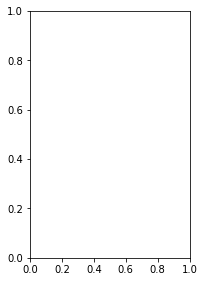

In [149]:
plt.figure(figsize=(20, 10))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plot_sent_trajectory(i, "blue")
plt.tight_layout()

<Figure size 1440x864 with 0 Axes>

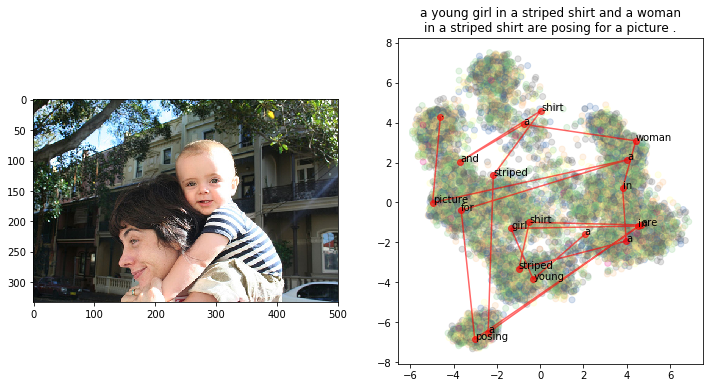

In [292]:
plt.figure(figsize=(20, 12))
img_idx = 10
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(load_image(img_idx))
plt.subplot(1, 2, 2)
plot_sent_trajectory(img_idx, "red")

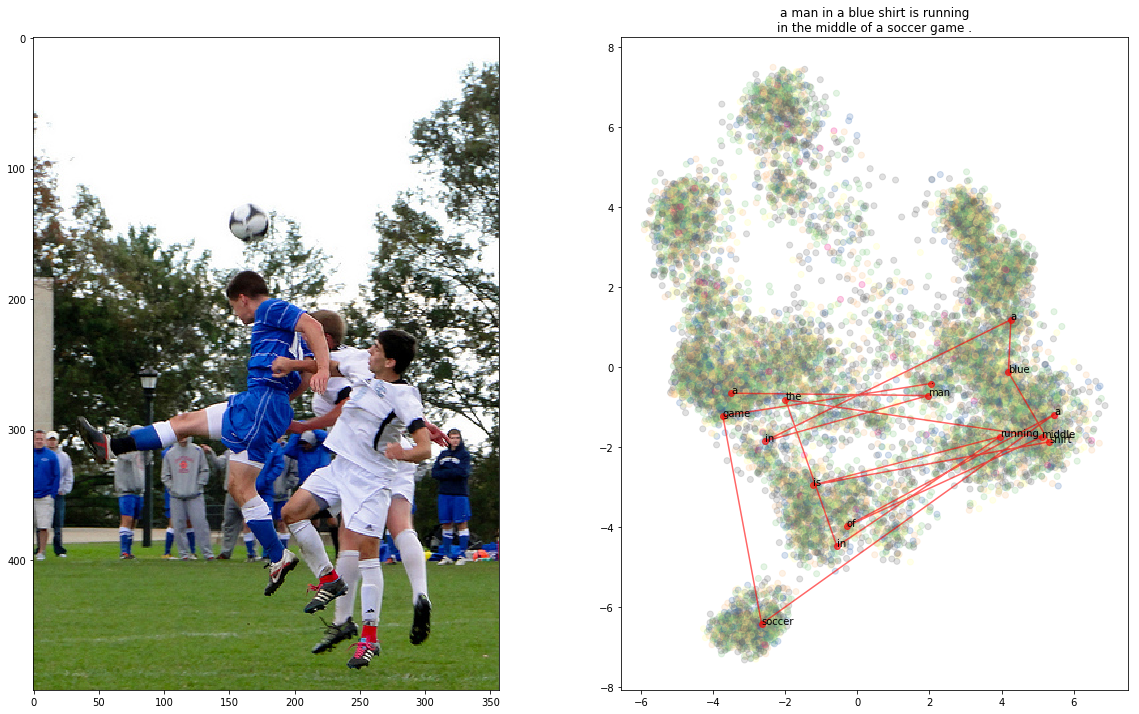

In [293]:
img_idx = 900
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(load_image(img_idx))
plt.subplot(1, 2, 2)
plot_sent_trajectory(img_idx, "red")

Running clockwise?

Latent space by pos

In [152]:
X_pos = [p for pos in en_sents_pos_1 for p in pos]

NameError: name 'en_sents_pos_1' is not defined

In [151]:
X_pos = [p for pos in en_sents_pos_1 for p in pos]
X_hidden = []
pca = PCA(n_components=2)
en_pca_1 = pca.fit_transform(X_en_sents_1)
np.stack(X_en_sents_1).shape

NameError: name 'en_sents_pos_1' is not defined

In [186]:
np.sum(X_recon_captions_lens_1)

14652

In [187]:
print(X_recon_captions_lens_1[513])
len(en_recon_captions_1[513].split())
print(en_recon_captions_1[513].split())
print(en_sents_pos_1[513])
print(list(zip(en_sents_pos_1[513], 
          en_recon_captions_1[513].split(), en_sents_tokens_1[513])))

13
['a', 'man', 'in', 'shorts', 'and', 'a', 't-shirt', 'is', 'walking', 'on', 'the', 'beach', '.']
['DET', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'DET', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', 'PUNCT']
[('DET', 'a', 'a'), ('NOUN', 'man', 'man'), ('ADP', 'in', 'in'), ('NOUN', 'shorts', 'shorts'), ('CCONJ', 'and', 'and'), ('DET', 'a', 'a'), ('NOUN', 't-shirt', 't-shirt'), ('VERB', 'is', 'is'), ('VERB', 'walking', 'walking'), ('ADP', 'on', 'on'), ('DET', 'the', 'the'), ('NOUN', 'beach', 'beach'), ('PUNCT', '.', '.')]


In [188]:
mask = np.array([len(s) for s in en_sents_pos_1]) == np.array(X_recon_captions_lens_1)
[i for i in range(len(mask)) if not mask[i]]

[]

In [246]:
import matplotlib as mpl
cols = mpl.cm.viridis_r.colors
mpl.cm.viridis_r.N

256

In [150]:
from matplotlib import colors as mcolors
name2hex = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
hex2name = {v:k for k, v in name2hex.items()}
cols = list(mcolors.CSS4_COLORS.values())
pos_categories = set(X_pos)

pos_categories_ints = [c for c in range(len(pos_categories))]
pos2color = {c: i for i , c in enumerate(pos_categories)}
color2pos = {i: c for i , c in enumerate(pos_categories)}
X_colors = list(map(lambda x: pos2color[x], X_pos))

# cols = {c: h for c, h in zip(pos_categories, cols)}
# color_list = list(map(lambda x: cols[x], X_pos));
# color_name_list = list(map(lambda x: hex2name[x], color_list))

NameError: name 'X_pos' is not defined

No handles with labels found to put in legend.


{('antiquewhite', 'CCONJ'), ('brown', 'NOUN'), ('black', 'PART'), ('blue', 'ADV'), ('aliceblue', 'DET'), ('beige', 'VERB'), ('aquamarine', 'ADP'), ('azure', 'NUM'), ('blanchedalmond', 'X'), ('bisque', 'ADJ'), ('cyan', 'PRON'), ('blueviolet', 'PUNCT')}


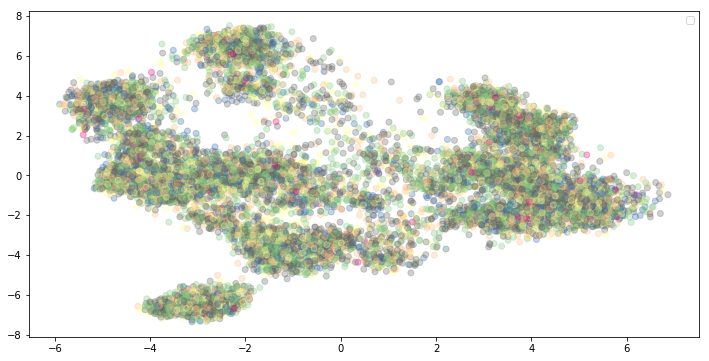

In [289]:
print(set(list(zip(color_name_list, X_pos))))
plt.figure(figsize=(12, 6))
idxs_order = np.random.permutation(range(en_pca.shape[0]))
plt.scatter(en_pca[idxs_order, 0], 
            en_pca[idxs_order, 1], c=X_colors, cmap='Accent', alpha=0.3)
plt.gca().legend()